Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Environment Setup

In [1]:
!apt-get install -y graphviz
!pip install pydot graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


GPU Check

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

Dataset Path & Parameters

In [4]:
DATASET_PATH = "/content/drive/MyDrive/First_Set"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 30
NUM_CLASSES = 2

Data Generators

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 424 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 528 images belonging to 2 classes.


Class Labels

In [6]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['100x_Normal_Oral_Cavity_Histopathological_Images',
 '100x_OSCC_Histopathological_Images']

Load VGG16 (Transfer Learning)

In [7]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Custom Classification Head

In [8]:
x = base_model.output
x = Flatten()(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

Compile Model

In [9]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           25

 Total params: 21,170,626 (80.76 MB)

 Trainable params: 6,455,938 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Callbacks

In [10]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/oral_cancer_vgg16_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

Train Model

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.7831 - loss: 0.6600 - val_accuracy: 0.8365 - val_loss: 0.4135
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 737ms/step - accuracy: 0.7683 - loss: 0.5228 - val_accuracy: 0.8365 - val_loss: 0.4250
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 715ms/step - accuracy: 0.7890 - loss: 0.5579 - val_accuracy: 0.8365 - val_loss: 0.4178
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 709ms/step - accuracy: 0.7942 - loss: 0.4376 - val_accuracy: 0.8365 - val_loss: 0.4034
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 768ms/step - accuracy: 0.8237 - loss: 0.4515 - val_accuracy: 0.8365 - val_loss: 0.3801
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 765ms/step - accuracy: 0.8278 - loss: 0.4624 - val_accuracy: 0.8365 - val_loss: 0.3776
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 754ms/step - accuracy: 0.8303 - loss: 0.3927 - val_accuracy: 0.8365 - val_loss: 0.3944
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - accuracy: 0.7813 - loss: 0.4513 - val_accura

Training Curves

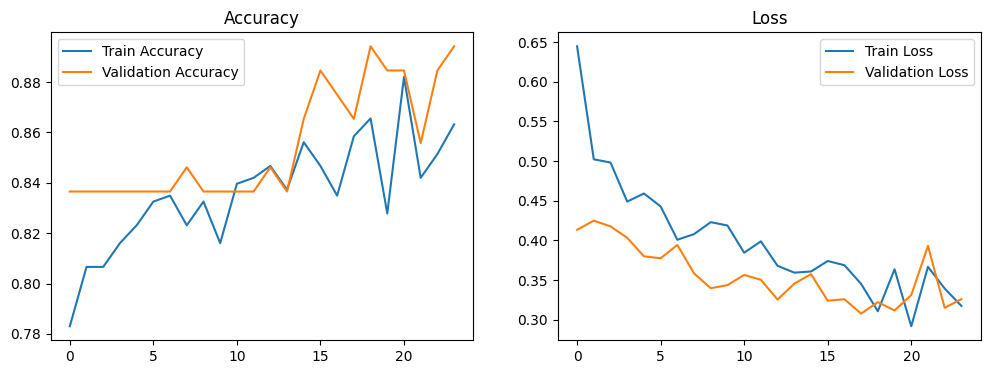

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

Evaluation Utility

In [13]:
def evaluate_model(generator, model):
    generator.reset()
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1-score": f1_score(y_true, y_pred, average="weighted")
    }

Train / Validation / Test Metrics

In [14]:
train_metrics = evaluate_model(train_generator, model)
val_metrics = evaluate_model(val_generator, model)
test_metrics = evaluate_model(test_generator, model)

metrics_df = pd.DataFrame.from_dict(
    {
        "Training": train_metrics,
        "Validation": val_metrics,
        "Test": test_metrics
    },
    orient="index"
)

metrics_df

53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 583ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 503ms/step


,Accuracy,Precision,Recall,F1-score
Training,0.804245,0.732599,0.804245,0.757182
Validation,0.884615,0.898601,0.884615,0.856869
Test,0.878788,0.889205,0.878788,0.850392


Classification Report (Test Set)

In [15]:
test_generator.reset()
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print(classification_report(y_true, y_pred, target_names=class_labels))

66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step
                                                  precision    recall  f1-score   support

100x_Normal_Oral_Cavity_Histopathological_Images       0.96      0.29      0.45        89
              100x_OSCC_Histopathological_Images       0.87      1.00      0.93       439

                                        accuracy                           0.88       528
                                       macro avg       0.92      0.64      0.69       528
                                    weighted avg       0.89      0.88      0.85       528



Load the trained model

In [3]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/oral_cancer_vgg16_best.keras"
)

MODEL ARCHITECTURE VISUALIZATION

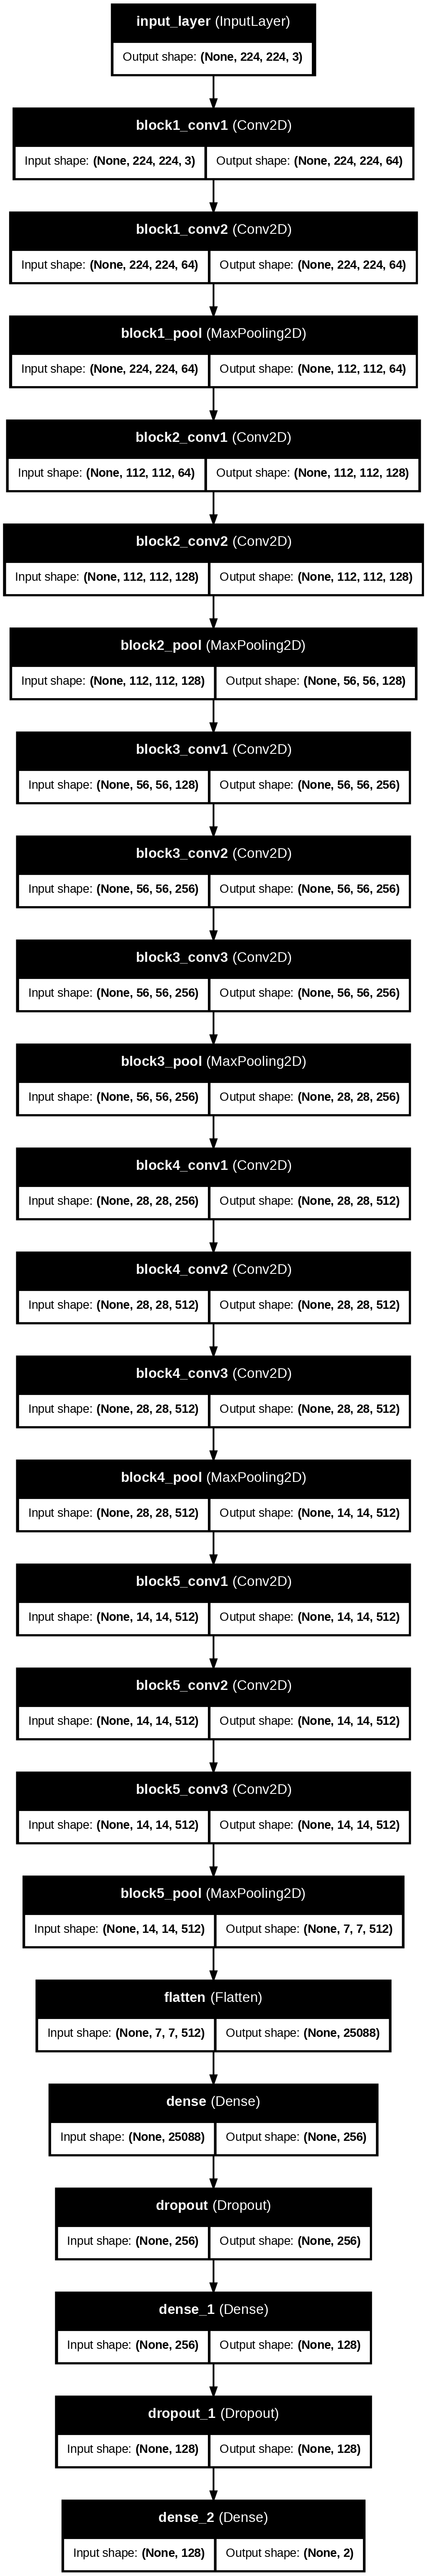

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="/content/drive/MyDrive/VGG16_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=150
)